### Plot 1: Rate on investment under different betting strategies

**Description:**  The natural metric for predictive success in tennis is whether or not the prediction algorithm can make money against the betting markets.  This clearly depends on a betting strategy.  The plot below sketches results under three different betting regimes:

1.  **Strategy 1:** Bet a fixed amount $q$  on the higher ranked player, regardless of the difference in ranking points.  In this simulation, $q$ is taken to be $\$1$.   
2.  **Strategy 2:** Bet a fixed amount $q$ on the higher ranked player, but only if our assessed probability, say $p_1$, exceeds the implied probability of the odds market, say $p_2$.  
3.  **Strategy 3:** Bet an amount that grows or shrinks depending on by how much our probability exceeds that of the implied probabilty.  We use the Kelly criterion, where the amount staked is given by 
$$
q\frac{p \cdot (b+1)-1}{b}
$$ 
for some parameter $b$.


To generate this plot, we first run logistic regression on a training set, and use the resulting probability curve, together with the implied probabilities from the betting markets, to implement the above three betting strategies on the validation set.  While odds are published from a variety of betting houses, we use the ones from Pinnacle, whihc tend to be highest.  In all these simulations, we assume that the bettor starts with enough money to bankroll the entire series of matches.  

<img src="image2.png",width=800,height=500>



** Code for producing the plot:**

In [1]:
import numpy as np # numerical libraries
import pandas as pd # for data analysis
import matplotlib as mpl # a big library with plotting functionality
import matplotlib.pyplot as plt # a subset of matplotlib with most of the useful tools
import IPython as IP
%matplotlib inline 
import pdb
from sklearn import linear_model as lm

Load and preprocess the data.

In [2]:
odds= pd.read_pickle('./data/pickle_files/odds.pkl')
matches= pd.read_pickle('./data/pickle_files/matches.pkl')
data = pd.merge(matches,odds[['PSW','PSL','key_o']].dropna(axis=0,subset=["PSW"]),how='inner',on='key_o')
data = data[~data.winner_rank_points.isnull() & ~data.loser_rank_points.isnull()]

data['year'] = data['tourney_date'].map(lambda x: x.year)
training = data[data.year.isin([2010,2011,2012])]
validation = data[data.year.isin([2013,2014])]
test = data[data.year.isin([2015,2016])]

# consider rank difference to be positive if winner higher ranked, otherwise negative
rank_diff = (training['winner_rank_points'] - training['loser_rank_points']).values
# if higher ranked player won, raw rank was a successful predictor
y = (rank_diff > 0)*1
# predictions done *before* the match, so algorithm operates on absolute value of rank difference 
X = np.abs(rank_diff)
# for numerical well-behavedness, we need to scale and center the data
X=(X/np.std(X,axis=0))

Perform the logistic regression.

In [5]:
lr = lm.LogisticRegression(C=1., solver='lbfgs')
lr.fit(X.reshape(len(X),-1),y*1)
r = lr.coef_[0]

*Strategy 1:  bet fixed amount on predicted winner.*

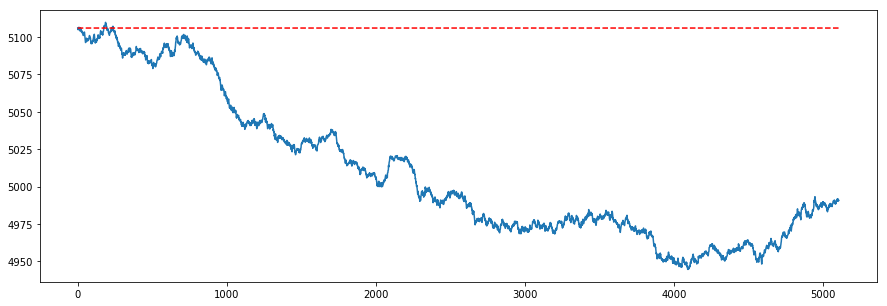

In [6]:
investment = len(validation)
good_call_idx1 = (validation['loser_rank_points']-validation['winner_rank_points']<0).values
winner_odds = validation["PSW"].values
daily_gains1 = winner_odds*good_call_idx1 
daily_cost1 = -np.ones(len(validation))
daily_movement1 = daily_cost1 + daily_gains1
daily_balances1=np.zeros(len(validation))
daily_balances1[0]=investment
for i in np.arange(1,len(validation)):
    daily_balances1[i]+=daily_balances1[i-1]+daily_movement1[i]

plot_bnd = len(validation)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(daily_balances1[0:plot_bnd])
x = np.arange(len(validation))
tick = np.ones(len(validation))
ax.plot(x[0:plot_bnd],investment*tick[0:plot_bnd],'--r')


*Strategy 2:  bet fixed amount if predicted probability exceeds implied probability*

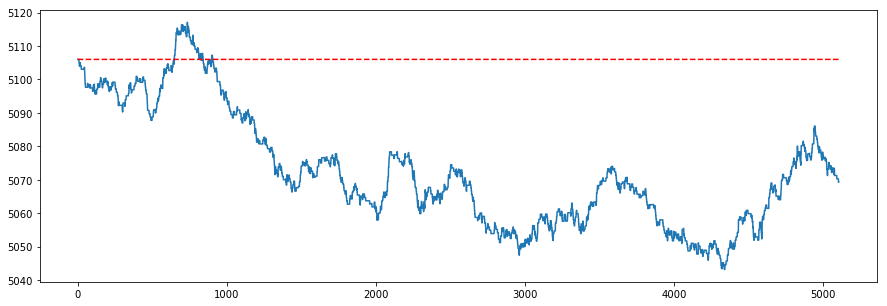

In [7]:
# normalize the data
rank_diff = (validation['winner_rank_points'] - validation['loser_rank_points']).values
y = (rank_diff > 0)
X = np.abs(rank_diff)
X=(X/np.std(X,axis=0))

# figure out on whom you would have bet, and calculate implied odds
ProbW = 1/validation.PSW
ProbL = 1/validation.PSL
compProbs = np.where(y,ProbW,ProbL)

# bet if your odds are higher
myProbs = 1/(1+np.exp(-r*X))
bet_placed_idx = (myProbs>compProbs)
good_call_idx2 = (validation['loser_rank_points']-validation['winner_rank_points']<0).values
daily_cost2 = np.zeros(len(validation))
daily_cost2[bet_placed_idx]=-1
winner_odds = validation["PSW"].values
daily_gains2 = winner_odds*(bet_placed_idx*good_call_idx2)
daily_movement2 = daily_cost2 + daily_gains2
daily_balances2=np.zeros(len(validation))
daily_balances2[0]=investment
for i in np.arange(1,len(validation)):
    daily_balances2[i]+=daily_balances2[i-1]+daily_movement2[i]

plot_bnd = len(validation)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(daily_balances2[0:plot_bnd])
x = np.arange(len(validation))
tick = np.ones(len(validation))
ax.plot(x[0:plot_bnd],investment*tick[0:plot_bnd],'--r')


*Strategy 3:  Kelly criterion*

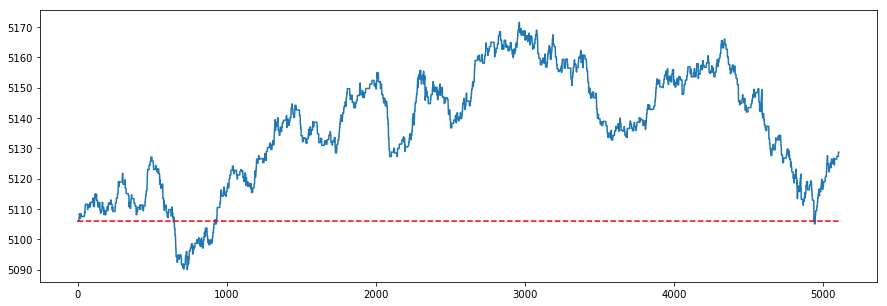

In [8]:
# modify bet if your odds are higher
b = .25 # arbitrary--futz with this
myProbs = 1/(1+np.exp(-r*X))
myBets = (myProbs*(b+1)-1)/b
bet_placed_idx = (myProbs>compProbs)
good_call_idx3 = (validation['loser_rank_points']-validation['winner_rank_points']<0).values
daily_cost3 = np.zeros(len(validation))
daily_cost3[bet_placed_idx]= -myBets[bet_placed_idx]
winner_odds = validation["PSW"].values
daily_gains3 = (winner_odds*(bet_placed_idx*good_call_idx3))*myBets
daily_movement3 = daily_cost3 + daily_gains3
daily_balances3=np.zeros(len(validation))
daily_balances3[0]=investment
for i in np.arange(1,len(validation)):
    daily_balances3[i]+=daily_balances3[i-1]+daily_movement3[i]

plot_bnd = len(validation)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(daily_balances3[0:plot_bnd])
x = np.arange(len(validation))
tick = np.ones(len(validation))
ax.plot(x[0:plot_bnd],investment*tick[0:plot_bnd],'--r')

*Put the three plots together and polish things up.*

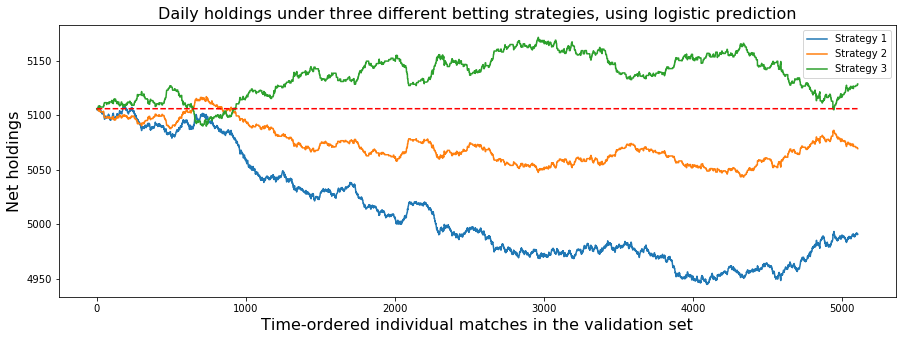

In [9]:
plot_bnd = len(validation)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(daily_balances1[0:plot_bnd])
ax.plot(daily_balances2[0:plot_bnd])
ax.plot(daily_balances3[0:plot_bnd])
x = np.arange(len(validation))
tick = np.ones(len(validation))
ax.plot(x[0:plot_bnd],investment*tick[0:plot_bnd],'--r')
ax.set_xlabel('Time-ordered individual matches in the validation set',fontsize=16)
ax.set_ylabel('Net holdings',fontsize=16)
ax.set_title('Daily holdings under three different betting strategies, using logistic prediction',fontsize=16)
ax.legend(['Strategy 1','Strategy 2','Strategy 3'])